  # Autoencoder - SNNL Dev

# Setup

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import os
import sys
import csv
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from typing import Dict, List, Tuple


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary
import wandb

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-SNNL-MAIN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.set_num_threads(4)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


4

In [5]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace, print_heading, print_underline

import snnl.utils as utils
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import plot_model_parms, plot_train_history, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import define_autoencoder_model, init_resume_training

In [6]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-19 20:11:37,860 - __main__ - INFO: -  Excution started : 2024_09_19_20:11:37 
2024-09-19 20:11:37,861 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 4
2024-09-19 20:11:37,862 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-09-19 20:11:37,863 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


### main(args)

In [13]:
GPU_ID = 0
LATENT_DIM    = 250
HIDDEN_1      = 512
EPOCHS        = 100
LEARNING_RATE = 1.00e-03
TEMP          = 1.00
TEMP_LR       = 0.00   ##1.0e-05

SNNL_FACTOR = 3.0
COMPOUNDS_PER_BATCH = 600
ADAM_WEIGHT_DECAY = 0.001
RUN_DATETIME = "20240917_2004"

LOAD_EPOCH = 100
CHECKPT = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{RUN_DATETIME}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
RUN_ID        = "kfzmaqko"
print(CHECKPT)

AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt


In [14]:
# if __name__ == "__main__":
cli_args = f" --runmode             snnl "\
            f" --configuration      ./hyperparameters/ae_snglopt_{LATENT_DIM}_512_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --single_loss        "\
            f" --prim_opt           "\
            f" --temp_annealing     "\
            f" --anneal_patience    30"\
            f" --adam_wd            {ADAM_WEIGHT_DECAY}"\
            f" --lr                 {LEARNING_RATE} "\
            f" --temp               {TEMP} "\
            f" --snnl_factor        {SNNL_FACTOR}"\
            f" --temp_lr            {TEMP_LR}"\
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --gpu_id             {GPU_ID} "  \
            f" --wandb              "\
            f" --run_id             {RUN_ID} "\
            f" --ckpt               {CHECKPT} " \
            f" "

# f" --loss_factor        {LOSS_FACTOR}"\
# f" --temp_opt " \
# f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
# f" --exp_title           snglOpt-050Ltnt_512_sig "
cli_args = utils.parse_args(cli_args.split())
cli_args

args = utils.load_configuration(cli_args)
args.ckpt

Namespace(configuration='./hyperparameters/ae_snglopt_250_512_cpb.yaml', ckpt='AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt', cpb=600, exp_title=None, epochs=100, gpu_id=0, learning_rate=0.001, exp_id='kfzmaqko', runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=True, anneal_patience=30, use_single_loss=True, temperature=1.0, adam_weight_decay=0.001, loss_factor=None, snnl_factor=3.0, temperatureLR=0.0, WANDB_ACTIVE=True)

2024-09-19 20:12:27,319 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [./hyperparameters/ae_snglopt_250_512_cpb.yaml]
2024-09-19 20:12:27,319 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt]
2024-09-19 20:12:27,320 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [600]
2024-09-19 20:12:27,320 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-19 20:12:27,321 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [100]
2024-09-19 20:12:27,321 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [0]
2024-09-19 20:12:27,322 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [0.001]
2024-09-19 20:12:27,322 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    

['AE', 'snnl', 'dcpb600', '250Ltnt', '512', '20240917', '2004', 'LAST', 'ep', '100.pt']


'AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt'

In [16]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0.0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_st

In [17]:
### Set random seed and gpu device
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    args.current_device = set_device(args.gpu_id)
    print(f" args.current_device is : {args.current_device}")

2024-09-19 20:12:32,982 - __main__ - INFO: - Checkpoint AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt found
2024-09-19 20:12:32,983 - __main__ - INFO: - Resuming training using checkpoint: AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt


 device: 0   Quadro GV100                   :  free: 33,423,949,824 B   (31.13 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 33,073,725,440 B   (30.80 GB)    total: 34,069,872,640 B   (31.73 GB)


2024-09-19 20:12:33,648 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-19 20:12:33,649 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 0


 device: 2   NVIDIA TITAN Xp                :  free: 12,464,029,696 B   (11.61 GB)    total: 12,774,539,264 B   (11.90 GB)
 args.current_device is : cuda:0


  ### WandB Setup

In [18]:
wandb_run = utils.setup_wandb(args)

2024-09-19 20:12:36,545 - snnl.utils.utils_notebook - INFO: - ***** Resume EXISTING W&B Run *****
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find AE-SNNL-MAIN.ipynb.


kfzmaqko, AE_20240917_2004, CellPainting_Profiles


wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


2024-09-19 20:12:38,535 - snnl.utils.utils_notebook - INFO: -  Experiment Name  : AE_20240917_2004
2024-09-19 20:12:38,536 - snnl.utils.utils_notebook - INFO: -  Experiment Date  : 20240917_2004
2024-09-19 20:12:38,537 - snnl.utils.utils_notebook - INFO: - ***** Resume EXISTING W&B Run *****
2024-09-19 20:12:38,538 - snnl.utils.utils_notebook - INFO: - WANDB_ACTIVE     : True
2024-09-19 20:12:38,539 - snnl.utils.utils_notebook - INFO: - Project Name     : CellPainting_Profiles
2024-09-19 20:12:38,541 - snnl.utils.utils_notebook - INFO: - Experiment Id    : kfzmaqko
2024-09-19 20:12:38,542 - snnl.utils.utils_notebook - INFO: - Experiment Name  : AE_20240917_2004
2024-09-19 20:12:38,543 - snnl.utils.utils_notebook - INFO: - Experiment Date  : 20240917_2004
2024-09-19 20:12:38,544 - snnl.utils.utils_notebook - INFO: - Experiment Title : dcpb600_250Ltnt_512
2024-09-19 20:12:38,544 - snnl.utils.utils_notebook - INFO: - Experiment Notes : AE snnl - DualOpt, 250 dim latent, 512 Midlayer, 600 

In [19]:
# if args.WANDB_ACTIVE:
#     wandb_run.finish()
#     WANDB_ACTIVE = False

  ### Define dataset and dataloaders

In [22]:
## Validation : 24,000
## Test: 12,000
## Train : 312,000 - (24,000+12,000) = 276,000
# cellpainting_args = {'sample_size': 3,
#                      'batch_size': 1,
#                      'compounds_per_batch': 600,
#                      'training_path'  : ALL_INPUT,
#                      'validation_path': ALL_INPUT,
#                      'test_path'      : ALL_INPUT,
#                      'train_start'    : 0,
#                      'train_end'      : 276_000,
#                      'val_start'      : 276_000,
#                      'val_end'        : 300_000,
#                      'test_start'     : 300_000,
#                      'test_end'       : 312_000,   ## 34_542
#                      }
# 
# args.cellpainting_args

In [23]:
# ## total rows = 346,542
# ## Validation :  24,542
# ## Train :      312,000 
args.cellpainting_args['training_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['train_start'] = 0 
args.cellpainting_args['train_end'] = 324_000

args.cellpainting_args['validation_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['val_start'] = 324_000
args.cellpainting_args['val_end'] = 346_542

In [24]:
#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val'])
len(data_loaders['train']),len(data_loaders['val'])

2024-09-19 20:13:18,049 - root - INFO: -  load cellpainting
2024-09-19 20:13:18,051 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-19 20:13:18,052 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
2024-09-19 20:13:18,053 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-19 20:13:18,054 - snnl.utils.dataloader - INFO: -  start   :  0
2024-09-19 20:13:18,055 - snnl.utils.dataloader - INFO: -  end     :  324000
2024-09-19 20:13:18,056 - snnl.utils.dataloader - INFO: -  numrows :  324000
2024-09-19 20:13:18,057 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-19 20:13:18,058 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-19 20:13:18,059 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-19 20:13:18,060 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  600
2024-09-19 20:13

 load cellpainting
 Dataset size: 324000   rows per batch: 1800
 Dataset size: 22542   rows per batch: 1800


(324000, 22542)

In [25]:
# -----------------------------------------
#  Count pos/neg labels in each dataset
# -----------------------------------------  
MINIBATCH_SIZE = args.cellpainting_args['sample_size'] * args.cellpainting_args['compounds_per_batch']
train_minibatches = len(data_loaders['train']) // MINIBATCH_SIZE
val_minibatches = len(data_loaders['val']) // MINIBATCH_SIZE
# test_minibatches = len(data_loader['test']) // MINIBATCH_SIZE
print(f" Minibatch size : {MINIBATCH_SIZE:6d}") 
print(f" len of train data loader: {len(data_loaders['train']):7d}   number of batches: {train_minibatches:4d}    last batch: {len(data_loaders['train']) % MINIBATCH_SIZE:4d}")
print(f" len of valid data loader: {len(data_loaders['val']):7d}   number of batches: {val_minibatches:4d}    last batch: {len(data_loaders['val']) % MINIBATCH_SIZE:4d}")
# print(f" len of test  data loader: {len(data_loader['test'])}   number of batches: {test_minibatches}")

 Minibatch size :   1800
 len of train data loader:  324000   number of batches:  180    last batch:    0
 len of valid data loader:   22542   number of batches:   12    last batch:  942


In [25]:
from tqdm import tqdm
for datatype in ['train', 'val' ]:
    ttl_rows = 0
    ttl_pos_labels = 0 
    with tqdm(enumerate(data_loaders[datatype]), initial=0, total = train_minibatches, position=0, file=sys.stdout,
                   leave= False, desc=f" Read {datatype} ") as t_warmup:
        for batch_count, (batch_features, batch_labels, _, _, _, _) in t_warmup:
            ttl_rows += batch_labels.shape[0]
            ttl_pos_labels += batch_labels.sum()

    ttl_neg_labels = ttl_rows - ttl_pos_labels
    print(f"\n Dataset: {datatype}")
    print('-'*30)
    print(f" total rows     : {ttl_rows:7d}")
    print(f" total pos rows : {ttl_pos_labels:7.0f} - {ttl_pos_labels*100.0/ttl_rows:5.2f}%")
    print(f" total neg rows : {ttl_neg_labels:7.0f} - {ttl_neg_labels*100.0/ttl_rows:5.2f}%")

                                                                                                                                                                           
 Dataset: train
------------------------------
 total rows     : 324000
 total pos rows :   38586 - 11.91%
 total neg rows :  285414 - 88.09%
                                                                                                                                                                           
 Dataset: val
------------------------------
 total rows     : 22542
 total pos rows :    2742 - 12.16%
 total neg rows :   19800 - 87.84%


# Define autoencoder model

### Override arguments

In [28]:
# args.temperature   = 1.0
# args.loss_factor   = 1.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   runmode               : {args.runmode}")
print(f"   embedding_layer       : {args.embedding_layer}")
print(f"   Latent dim            : {args.code_units}")
print(f"   loss_factor           : {args.loss_factor}")
print(f"   learning_rate         : {args.learning_rate}")
print(f"   use Primary Optimizer : {args.use_prim_optimizer}")
print(f"   use Primary Scheduler : {args.use_prim_scheduler}")
print(f"   snnl_factor           : {args.snnl_factor}")
print(f"   temperature           : {args.temperature}")
print(f"   use Temp Optimizer    : {args.use_temp_optimizer}")
print(f"   use Primary Scheduler : {args.use_temp_scheduler}")
print(f"   temperatureLR:        : {args.temperatureLR}")
print(f"   use_annealing:        : {args.use_annealing}")
print(f"   anneal_patience:      : {args.anneal_patience}")


   runmode               : snnl
   embedding_layer       : 4
   Latent dim            : 250
   loss_factor           : 1.0
   learning_rate         : 0.001
   use Primary Optimizer : True
   use Primary Scheduler : True
   snnl_factor           : 3.0
   temperature           : 1.0
   use Temp Optimizer    : False
   use Primary Scheduler : False
   temperatureLR:        : 0.0
   use_annealing:        : True
   anneal_patience:      : 30


In [29]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0.0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  324000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
    val_end..................  346542
    v

In [30]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)

'snnl'

2024-09-19 20:15:17,453 - snnl.utils.utils_notebook - INFO: - Defining model in SNNL mode 
2024-09-19 20:15:17,459 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-19 20:15:17,474 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-19 20:15:17,474 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-19 20:15:17,480 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-19 20:15:17,481 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    250    weights: [250, 512]   
2024-09-19 20:15:17,483 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    

 EMBEDDING LAYER: 4
 Device cuda:0 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'latent_code' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      Parameter containing:
tensor([1.])
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : latent_code
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu'

## Resume from model checkpoint (if args.ckpt is not None)

In [31]:
args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
# print(f" Checkpoint File :  {args.ckpt}")

model = init_resume_training(model, args)

if args.WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
    wandb.config.update(args)

2024-09-19 20:15:21,974 - root - INFO: - Load model checkpoint from  AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt
2024-09-19 20:15:22,063 - snnl.utils.utils_ptsnnl - INFO: -  Loaded from checkpoint AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_100.pt successfully. last epoch on checkpoint: 100
2024-09-19 20:15:22,065 - snnl.utils.utils_ptsnnl - INFO: -  Model best training metric   : 0.598703 - epoch: 65
2024-09-19 20:15:22,065 - snnl.utils.utils_ptsnnl - INFO: -  Model best validation metric : 0.617969 - epoch: 18
2024-09-19 20:15:22,067 - root - INFO: -  Loaded Model device cuda:0 -  Last completed epoch : 100
2024-09-19 20:15:22,067 - root - INFO: -  RESUME TRAINING - Run 100 epochs: epoch 101 to 200 


In [32]:
# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)
# for k,v in model.__dict__.items():
#     if k == 'training_history':
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v.keys()} ")
#     else:
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v} ")
# model.optimizers['prim'].state_dict()
# model.schedulers['prim'].state_dict()
# print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}")
# for k,v in model.optimizers.items():
#     print(k, v)
# for k,v in enumerate(model.optimizers['prim'].param_groups[0]['params']):
#     print(f" {k}, {v.shape}")

# Autoencoder Fit 

In [33]:
#
#  Running Training Loop
#
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-09-19 20:15:35,493 - __main__ - INFO: -  Experiment run id:  kfzmaqko
2024-09-19 20:15:35,494 - __main__ - INFO: -  Experiment Name  :  AE_20240917_2004 
2024-09-19 20:15:35,495 - __main__ - INFO: -  Experiment Date  :  20240917_2004 
2024-09-19 20:15:35,496 - __main__ - INFO: -  Experiment Title :  dcpb600_250Ltnt_512 
2024-09-19 20:15:35,497 - __main__ - INFO: -  Experiment Notes :  AE snnl - DualOpt, 250 dim latent, 512 Midlayer, 600 cpb


In [35]:
# model.starting_epoch = 0
model.ending_epoch = 200
# model.starting_epoch, model.ending_epoch = 700, 705
model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(100, 200)

 2024-09-19 20:15:48  epoch  101 of  200


In [40]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-20 19:46:53  Start: epoch  201 of  300
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
19:49:51 201/300  |  15.6137     0.4387    15.1750 |   0.373265   0.0000e+00 |   0.5218    65           |  17.0011     0.4356    16.5655 |   0.5296    18             |  1.250e-04   0.000e+00 |
19:52:50 202/300  |  15.6069     0.4400    15.1669 |   0.373265   0.0000e+00 |   0.5204    65           |  17.0111     0.4373    16.5739 |   0.5282    18             |  1.250e-04   0.000e+00 |              
19:55:49 203/300  |  15.6024     0.4413    15.1612 |   0.373265   0.0000e+00 |   0.5195    65           |  17.0018     0.4379    16.5638 |   0.5275    1

2024-09-20 22:06:27,921 - snnl.models.base - INFO: -  Main learning rate reduced to [6.25e-05]


22:06:27 247/300  |  15.0044     0.4951    14.5093 |   0.342923   0.0000e+00 |   0.4652    65           |  16.9171     0.4906    16.4265 |   0.4738    18             |  1.250e-04   0.000e+00 |
22:09:26 248/300  |  15.0362     0.4926    14.5435 |   0.342923   0.0000e+00 |   0.4715    65           |  16.8094     0.4888    16.3207 |   0.4738    18             |  6.250e-05   0.000e+00 |              
22:12:23 249/300  |  14.9617     0.4940    14.4678 |   0.342923   0.0000e+00 |   0.4703    65           |  16.8349     0.4912    16.3437 |   0.4715    18             |  6.250e-05   0.000e+00 |              
22:15:19 250/300  |  14.9132     0.4957    14.4174 |   0.342923   0.0000e+00 |   0.4684    65           |  16.8500     0.4935    16.3565 |   0.4692    18             |  6.250e-05   0.000e+00 |              
22:18:16 251/300  |  14.8778     0.4974    14.3804 |   0.342923   0.0000e+00 |   0.4668    65           |  16.8587     0.4951    16.3636 |   0.4675    18             |  6.250e-05   0.000

2024-09-21 00:42:53,406 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240917_2004_ep_300.pt - epoch: 300


00:42:53 300/300  |  13.8253     0.5531    13.2722 |   0.298653   0.0000e+00 |   0.4106    65           |  16.7953     0.5484    16.2469 |   0.4137    18             |  6.250e-05   0.000e+00 |
Last Epoch 300


2024-09-21 00:42:53,507 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240917_2004_LAST_ep_300.pt - epoch: 300


 2024-09-21 00:42:53  End: epoch  300 of  300


In [ ]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-21 06:29:18  Start: epoch  401 of  500
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
06:32:17 401/500  |  12.4378     0.6011    11.8366 |   0.254947   0.0000e+00 |   0.3646    65           |  16.7458     0.5953    16.1504 |   0.3683    18             |  1.563e-05   0.000e+00 |
06:35:18 402/500  |  12.4322     0.6014    11.8307 |   0.254947   0.0000e+00 |   0.3643    65           |  16.7537     0.5956    16.1580 |   0.3681    18             |  1.563e-05   0.000e+00 |              
06:38:18 403/500  |  12.4266     0.6017    11.8249 |   0.254947   0.0000e+00 |   0.3640    65           |  16.7539     0.5959    16.1581 |   0.3678    1

2024-09-21 07:59:13,820 - snnl.models.base - INFO: -  Main learning rate reduced to [7.8125e-06]


07:59:13 430/500  |  12.1035     0.6087    11.4948 |   0.243967   0.0000e+00 |   0.3569    65           |  16.7836     0.6027    16.1809 |   0.3608    18             |  1.563e-05   0.000e+00 |
08:02:10 431/500  |  12.1753     0.6082    11.5671 |   0.243967   0.0000e+00 |   0.3579    65           |  16.7436     0.6020    16.1416 |   0.3618    18             |  7.813e-06   0.000e+00 |              
08:05:08 432/500  |  12.1683     0.6081    11.5602 |   0.243967   0.0000e+00 |   0.3580    65           |  16.7396     0.6023    16.1373 |   0.3617    18             |  7.813e-06   0.000e+00 |              
08:08:02 433/500  |  12.1543     0.6082    11.5461 |   0.243967   0.0000e+00 |   0.3587    65           |  16.7355     0.6022    16.1333 |   0.3626    18             |  7.813e-06   0.000e+00 |              
08:10:56 434/500  |  12.1411     0.6083    11.5328 |   0.243967   0.0000e+00 |   0.3592    65           |  16.7351     0.6023    16.1328 |   0.3628    18             |  7.813e-06   0.000

In [ ]:
# model.use_temp_optimizer
# take_checkpoint(model, args, epoch=306, update_best = True)
# model.use_temp_optimizer
# model.temp_params
# model.anneal_patience = 30
# model.optimizers['prim'].param_groups[0]
# torch.get_num_threads()
# torch.set_num_threads(3)

In [46]:
model.epoch, model.starting_epoch, model.ending_epoch

(399, 300, 400)

In [50]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
20:16:29  1 /500  |  19.8031     0.6341    19.1690 |   1.000000   0.0000e+00 |  -4.5063    65           |  19.0093     0.4230    18.5863 |   0.3122    18             |  1.000e-03   0.000e+00 |
20:19:29  2 /500  |  19.0338     0.3991    18.6346 |   1.000000   0.0000e+00 |   0.3937    65           |  18.8383     0.3705    18.4678 |   0.5538    18             |  1.000e-03   0.000e+00 |
20:22:27  3 /500  |  18.9317     0.3717    18.5600 |   1.000000   0.0000e+00 |   0.5097    65           |  18.7954     0.3594    18.4360 |   0.5265    18             |  1.000e-03   0.000e+00 |
20:25:30  4 /500  |  18.8822     0.

In [48]:
# model.starting_epoch = 100
# model.ending_epoch = 200
# model.starting_epoch = 503
model.starting_epoch = model.ending_epoch
model.ending_epoch += 100

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240921_062909  epoch  401 of  500


### Close WandB Logging

In [51]:
if args.WANDB_ACTIVE:
    wandb_run.finish()
    args.WANDB_ACTIVE = False

temp_grad_hist,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_hist,███▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
temp_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_R2_score,██████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
trn_best_loss,███▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
trn_best_loss_ep,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
trn_best_metric,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_best_metric_ep,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_lr,███▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_prim_loss,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████████
trn_snn_loss,███▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁


## Misc stuff

In [ ]:
# for p in model.layers:
#     if hasattr(p, 'weight'):
#         p.weight.shape, p.bias.shape
# model.training_history['trn'].keys()
# # model.training_history['trn']['L04_W_grad']
# model.optimizers['prim']
# model.state_dict()['layers.0.weight']
# model.optimizers['prim'].zero_grad()
# layers.0.weight
# display_model_gradients(model, 'test')
# model.state_dict()['layers.0.weight'].requires_grad
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
# display_epoch_metrics(model, model.epoch, model.ending_epoch, header = True)

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.state_dict().keys()
# # for k in ['temperature', 'snnl_criterion.temperature'
# for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
#     if model.state_dict()[k].ndim > 1:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
#     else:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

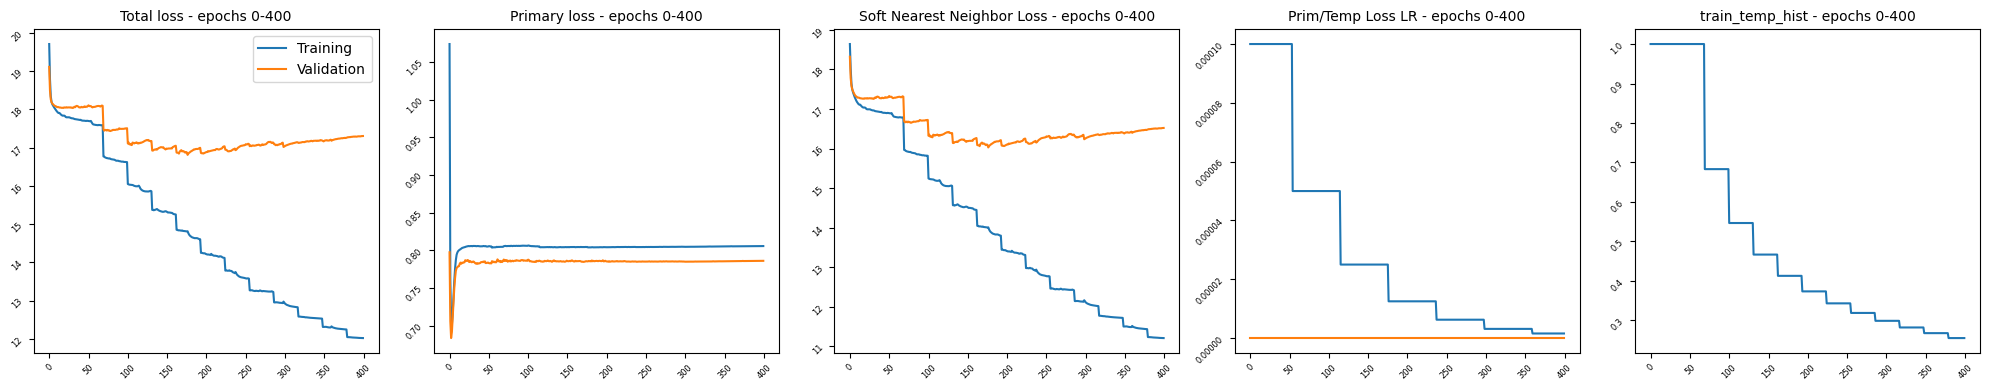

In [21]:
plot_train_history(model, start=0, n_bins = 25)

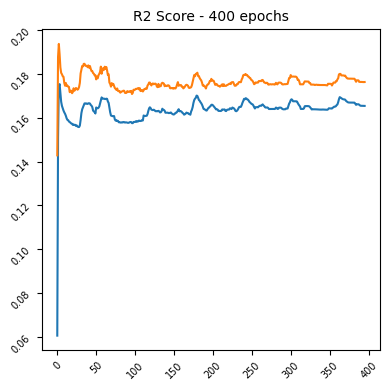

In [22]:
plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
# plot_train_metrics(model, n_bins = 25)
# plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= model.epoch, n_bins = 15)

# Load model

In [ ]:
ex_name = 'AE'
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240718'
ex_time = '1956'
ex_title = args.exp_title
compounds_per_batch = args.cpb
print(args.exp_title)
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
# ex_epoch = 200

In [ ]:
# filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_{ex_epoch:03d}.pt"
print(filename)
file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_BEST*.pt"
# file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_LAST*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
filename = filelist[0]
if filename[-3:] != '.pt':
    filename += '.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
# mdl , last_epoch = load_checkpoint_v2(model, filename)
mdl, last_epoch, mdl_ckpt = utils.load_checkpoint_v5(model, filename)
print(f" last epoch : {last_epoch}")

In [ ]:
print(args.current_device)
print(mdl.device)
# model.device = current_device
print(mdl.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs,

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device              : {model.device}")
print(f" model temperature         : {model.temperature}")
print(f" model use prim_optimizer  : {model.use_prim_optimizer}")
print(f" model use prim_scheduler  : {model.use_prim_scheduler}")
print() 
print(f" loss_factor               : {model.loss_factor}")
print(f" monitor_grads_layer       : {model.monitor_grads_layer}")
print(f" Learning rate             : {model.optimizers['prim'].param_groups[0]['lr']}") 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}") 
print() 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].state_dict()}") 

print(f" snnl_factor               : {model.snnl_factor}")
# if model.use_snnl:
#     print(f" temperature          : {model.temperature.item()}")
# if model.temp_optimizer is not None:
#     print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
# print()

# for th_key in ['trn', 'val']:
#     for k,v in model.training_history[th_key].items():
#         if isinstance(v[-1],str):
#             print(f" {k:20s} : {v[-1]:s}  ")
#         else:
#             print(f" {k:20s} : {v[-1]:6f} ")
#     print()


In [ ]:
model.optimizers['prim']['params']
# model.use_prim_scheduler

In [ ]:
model.optimizers 
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__